# Implementing an autodiff version of the MAP inference from Lawrence et al. 2007

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import autograd
from autograd import grad, elementwise_grad
import autograd.numpy as np
#import autograd.scipy.stats.norm as norm
#from autograd.scipy.special import erf
#from autograd.scipy.special import expit as sigmoid
from autograd.numpy.linalg import solve, cholesky
from autograd.misc.optimizers import adam
from autograd.misc.flatten import flatten_func

In [3]:
def odesol_full(params):
    D1,D2 = params['decays']
    S1,S2 = params['couplings']
    f = params['f']

    t_vec = np.arange(1/grid, T+1/grid, 1/grid)
    quad1 = np.exp(D1*t_vec)*f
    quad2 = np.exp(D2*t_vec)*f
    return  S1*np.exp(-D1*t_vec)*np.cumsum(quad1), S2*np.exp(-D2*t_vec)*np.cumsum(quad2)

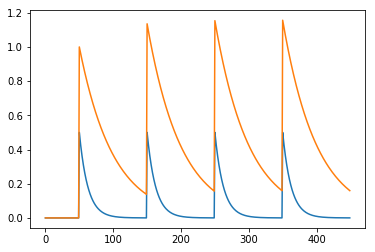

In [5]:
T=450
tvec=range(T)
latentf = np.zeros([T,])
latentf[[50,150,250,350]] = 1
grid = 1

trupar = {'decays':np.array([0.08,0.02]),
          'couplings':np.array([0.5,1.]),
          'f':np.array(latentf)}

SM1,SM2 = odesol_full(trupar)
plt.plot(tvec, SM1 )
plt.plot(tvec, SM2 )

In [6]:
def obj(params,itr):
    SM_est1, SM_est2 = odesol_full(params)
    MSE1 = np.mean( (SM_est1 - SM1)**2 )
    MSE2 = np.mean( (SM_est2 - SM2)**2 )
    return MSE1 + MSE2

In [7]:
# init
init_params = {'decays':np.array([0.5,0.5]),
              'couplings':np.array([0.5,.5]),
              'f':0*np.array(latentf)}
# flatten and take gradient
flat_obj, unflatten, flat_init_params = flatten_func(obj, init_params)
flat_obj_grad = grad(flat_obj)
# first iteration
optimized_params = adam(flat_obj_grad, flat_init_params, step_size=0.01, num_iters=1)

/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  onp.add.at(A, idx, x)


In [8]:
float(flat_obj(flat_init_params,0))

/home/daniel/.conda/envs/samplecause37/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


0.2907990798583975

In [9]:
def callback(flatparams, itr, g):
    if not itr==0 and not itr%update_time:
        print(' EPOCH {} OBJ {}'.format(itr, float(flat_obj(flatparams,0)) ) )
update_time = 200

In [10]:
%%time
# spam this cell until covergence
optimized_params = adam(flat_obj_grad, optimized_params, step_size=0.01, num_iters=2500+1, callback = callback)
current_params = unflatten(optimized_params)
#print( '\n True params  B: {}  D: {}  S: {} \n'.format(trupar['theta'][0], trupar['theta'][1], trupar['theta'][2]) )

 EPOCH 200 OBJ 0.004180907279026978
 EPOCH 400 OBJ 0.0033127714092310526
 EPOCH 600 OBJ 0.00254725986867193
 EPOCH 800 OBJ 0.0023099677476735034
 EPOCH 1000 OBJ 0.0006347385170896935
 EPOCH 1200 OBJ 0.002462481469761152
 EPOCH 1400 OBJ 0.001941923666551179
 EPOCH 1600 OBJ 0.0007520871732687388
 EPOCH 1800 OBJ 0.0030358373669571114
 EPOCH 2000 OBJ 0.002045583851839403
 EPOCH 2200 OBJ 0.0012936354535211098
 EPOCH 2400 OBJ 9.372716830283737e-05
CPU times: user 7.63 s, sys: 12.1 ms, total: 7.64 s
Wall time: 8.07 s


In [11]:
current_params = unflatten(optimized_params)

([<matplotlib.lines.Line2D at 0x7f0873648940>],
 [<matplotlib.lines.Line2D at 0x7f08735edf98>])

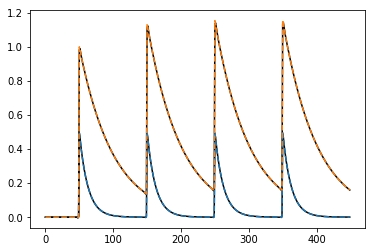

In [12]:
SM_est1,SM_est2 = odesol_full(current_params)
plt.plot(tvec, SM_est1, color='black'),plt.plot(tvec, SM_est2, color='black')
plt.plot(tvec, SM1,'--',color='C0'),plt.plot(tvec, SM2,'--',color='C1' )

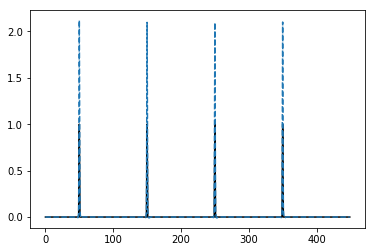

In [13]:
plt.plot(latentf,color='black')
plt.plot(tvec, current_params['f'],'--')

# Punchahole

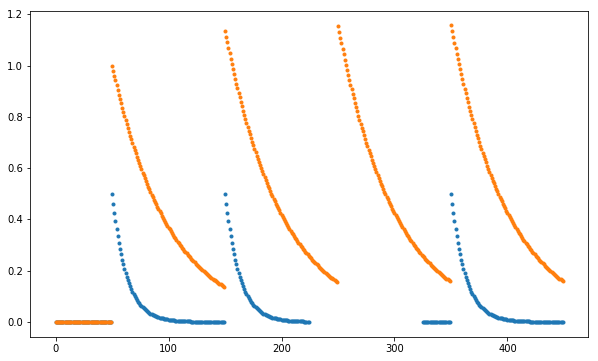

In [14]:
T=450
tvec=list(range(T))
latentf = np.zeros([T,])
latentf[[50,150,250,350]] = 1

trupar = {'decays':np.array([0.08,0.02]),
          'couplings':np.array([0.5,1.]),
          'f':np.array(latentf)}

SM1,SM2 = odesol_full(trupar)


#cut hole
cut=100
thole = np.concatenate([tvec[0: int(len(tvec)/2)], tvec[int(len(tvec)/2)+cut:]])
SM1 = np.concatenate([SM1[0: int(len(SM1)/2)], SM1[int(len(SM1)/2)+cut:]])

plt.figure(figsize=[10,6])
plt.plot(thole, SM1, '.' )
plt.plot(tvec, SM2, '.' )

In [15]:
def obj(params,itr):
    SM_est1, SM_est2 = odesol_full(params)
    SM_est1 = np.concatenate([SM_est1[0: int(len(SM_est1)/2)], SM_est1[int(len(SM_est1)/2)+cut:]])
    MSE1 = np.mean( (SM_est1 - SM1)**2 )
    MSE2 = np.mean( (SM_est2 - SM2)**2 )
    return MSE1 + MSE2

In [16]:
# init
init_params = {'decays':np.array([0.5,0.5]),
              'couplings':np.array([0.5,.5]),
              'f':0*np.array(latentf)}
# flatten and take gradient
flat_obj, unflatten, flat_init_params = flatten_func(obj, init_params)
flat_obj_grad = grad(flat_obj)
# first iteration
optimized_params = adam(flat_obj_grad, flat_init_params, step_size=0.01, num_iters=1)

In [17]:
def callback(flatparams, itr, g):
    if not itr==0 and not itr%update_time:
        print(' EPOCH {} OBJ {}'.format(itr, float(flat_obj(flatparams,0)) ) )
update_time = 200

In [18]:
%%time
# spam this cell until covergence
optimized_params = adam(flat_obj_grad, optimized_params, step_size=0.01, num_iters=2500+1, callback = callback)
current_params = unflatten(optimized_params)
#print( '\n True params  B: {}  D: {}  S: {} \n'.format(trupar['theta'][0], trupar['theta'][1], trupar['theta'][2]) )

 EPOCH 200 OBJ 0.004015714378579453
 EPOCH 400 OBJ 0.00317957450650042
 EPOCH 600 OBJ 0.0025189340997155375
 EPOCH 800 OBJ 0.0015451124580272398
 EPOCH 1000 OBJ 0.00226140889774831
 EPOCH 1200 OBJ 0.0016430575045185128
 EPOCH 1400 OBJ 0.00019368267897044883
 EPOCH 1600 OBJ 0.001313206436107976
 EPOCH 1800 OBJ 5.8781262769801244e-05
 EPOCH 2000 OBJ 8.597788029704434e-06
 EPOCH 2200 OBJ 0.00010971170634078051
 EPOCH 2400 OBJ 0.0001833548975776699
CPU times: user 8.24 s, sys: 12.7 ms, total: 8.25 s
Wall time: 8.27 s


In [19]:
current_params = unflatten(optimized_params)

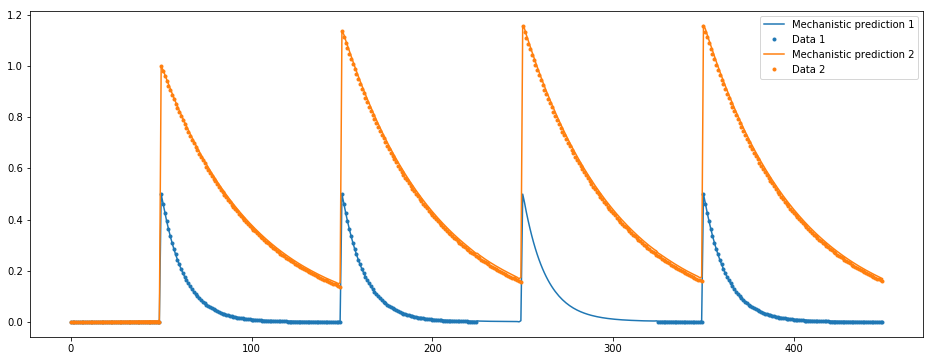

In [20]:
plt.figure(figsize=[16,6])
SM_est1,SM_est2 = odesol_full(current_params)
plt.plot(tvec, SM_est1, color='C0',label='Mechanistic prediction 1')
plt.plot(thole, SM1,'.',color='C0',label='Data 1')
plt.plot(tvec, SM_est2, color='C1',label='Mechanistic prediction 2')
plt.plot(tvec, SM2,'.',color='C1' ,label='Data 2')
plt.legend()

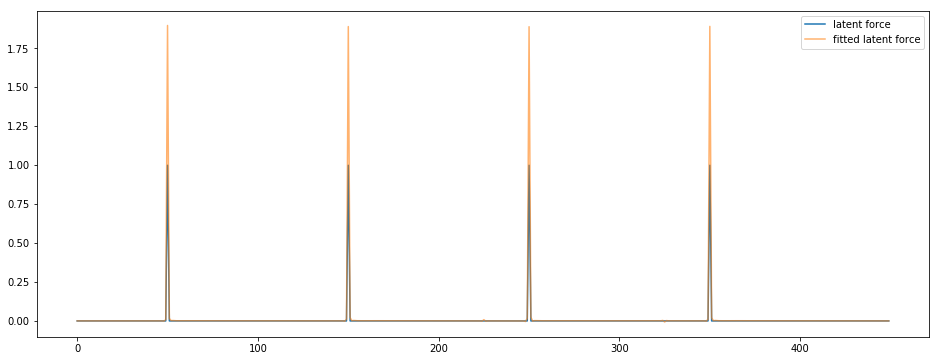

In [21]:
plt.figure(figsize=[16,6])
plt.plot(latentf,label='latent force')
plt.plot(tvec, current_params['f'],alpha=0.6,label='fitted latent force')
plt.legend()